In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('darkgrid')

In [3]:
%matplotlib inline

In [26]:
# loading the .xlsx to a pandas dataframe
vessel_df = pd.read_excel('particulars_dataset_jda_assignment.xlsx')

## EDA

In [5]:
vessel_df.head(5)

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP
0,9784269,5098185,15226,A,2019-01-01
1,9795622,5640800,21237,A,2019-01-01
2,9811000,5631605,20000,A,2019-01-01
3,9619983,157413,18270,A,2019-01-02
4,9695121,994728,19000,B,2019-01-02


In [6]:
vessel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   IMO        1202 non-null   int64         
 1   SHIP_ID    1202 non-null   int64         
 2   TEU        1202 non-null   int64         
 3   PORT_NAME  1202 non-null   object        
 4   TIMESTAMP  1202 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.1+ KB


Our dataset consists of 5 columns and 1202 rows. The row names are **IMO**, **SHIP_ID**, **TEU**, **PORT_NAME**, and **TIMESTAMP**.<br>

In more details:

1. **IMO**: refers to the IMO number of ships which is a unique identifier for ships
2. **SHIP_ID**: probably refers to a unique identifier set by marine traffic
3. **TEU**: stands for twenty-foot equivalent unit, and refers to the cargo capacity of a container vessel, meaning how many TEU a container vessel could carry.
4. **PORT_NAME**: refers to the 4 container ports
5. **TIMESTAMP**: refers to the date of arrival of the Ultra large container vessels

#### Missing values

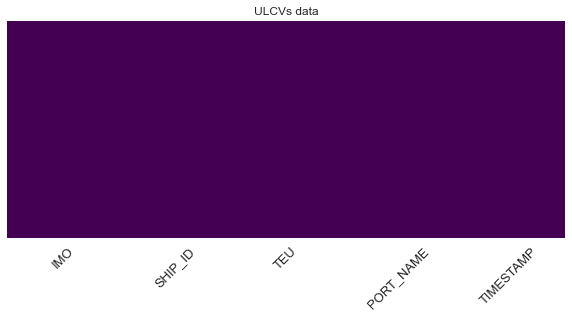

In [8]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,1,1)
sns.heatmap(vessel_df.isnull(),yticklabels=False,cbar=False,cmap='viridis', ax = ax1)
ax1.tick_params(axis='x', labelsize=13, rotation = 45)
ax1.set_title('ULCVs data');

In [9]:
vessel_df.isnull().sum()

IMO          0
SHIP_ID      0
TEU          0
PORT_NAME    0
TIMESTAMP    0
dtype: int64

**There are no missing values in our data set**

#### Duplicates

In [10]:
vessel_df.duplicated(keep=False).sum()

0

**All rows are unique**

### IMO feature

In [11]:
vessel_df.duplicated(subset=['IMO'], keep=False).sum()

1198

In [12]:
(~vessel_df.duplicated(subset=['IMO'], keep=False)).sum()

4

In [13]:
vessel_df['IMO'].nunique()

173

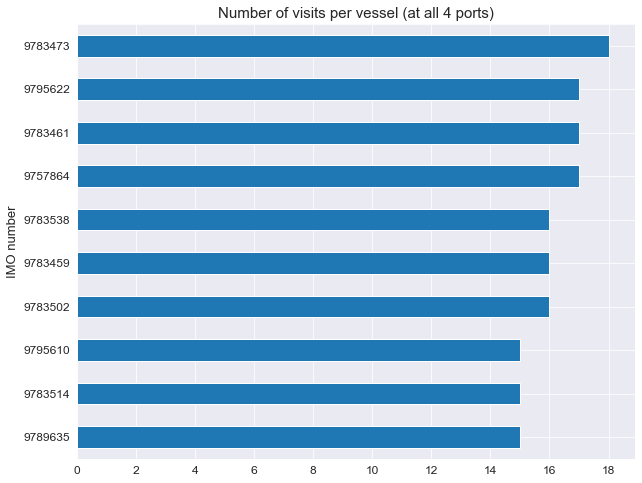

In [14]:
fig = plt.figure(figsize=(10,8))
vessel_df['IMO'].value_counts( ascending=True).iloc[-10:].plot(kind='barh')
plt.xticks(np.arange(0,20,2), fontsize=12)
plt.title('Number of visits per vessel (at all 4 ports)', fontsize=15)
plt.ylabel('IMO number', fontsize=13)
plt.yticks(fontsize=12);

From the above we notice the following:

1. Our data set consists of 173 unique ULCVs.
2. Only 4 ULCVs have visited those ports only once.
3. There are 4 ULCVs which have visited those ports a least 17 times.

#### TEU feature

#### Question A

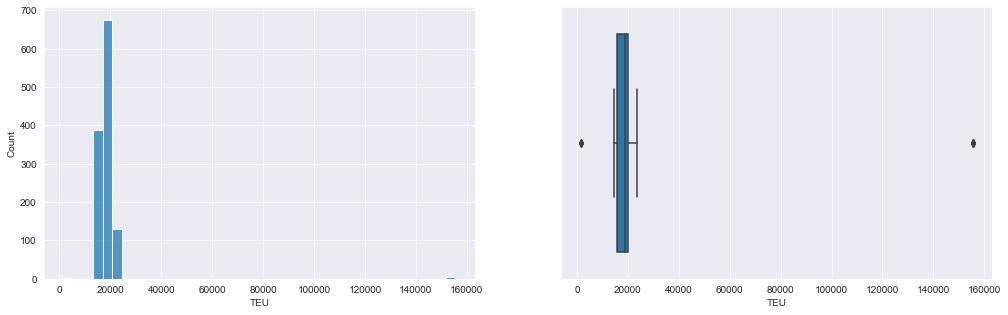

In [74]:
fig, axes = plt.subplots(1,2,figsize=(17,5))
sns.histplot(data = vessel_df, 
             x= 'TEU',  
             element='bars',
             stat='count',
            bins=40,
            ax=axes[0])
sns.boxplot(data = vessel_df, x = 'TEU',ax=axes[1]);

In [75]:
vessel_df['TEU'].describe()

count      1202.000000
mean      18756.699667
std        9186.091153
min        1555.000000
25%       15908.000000
50%       18800.000000
75%       20000.000000
max      155500.000000
Name: TEU, dtype: float64

In [94]:
# the below lambda functions can help us count how many outliners we have in this column. 
# I consider as an outliner a value which its absolute difference from the mean value of the TEU column is greater than 3 standard diviations
# However since we have a very large max value (155,000), while the majority of our data our centered within, it affects our mean value, so maybe not outliners could be spotted 
outliners = vessel_df['TEU'].apply(lambda x: True if np.abs(x - vessel_df['TEU'].mean()) > 3*vessel_df['TEU'].std() else False)
outliners.sum()

5

There are only 5 outliners. Since the dataset contains only ULCVs, there cannot be container vessles with 1,555 TEUs (min value). Also the max value of 155,500 TEUs is not feaseble.
We can suppose that fo both the lowest value for the max value some zeros had been misstyped.

There are many ways we could deal with those outliners.

1. We can simple drop those 5 rows, since there are very few and will not affect our data set.
2. Since there are only a few outliners, we could search based on the IMO number of the vessels and find the correct value of the TEUs (or check in the company's database).
3. We can replace them with the mean value of the TEU column, or even better with the mean value of TEU group by the port they have visited. Its common depending the vessel particulars, some vessel cannot visit all the ports.
4. Since there are many vessels appear more than one time in our data set, it is possible that their TEU values to had been misstyped just once, thus we could try to look and replace the outliners with their correct values

**Since there are only a few outliners we choose to find out the correct values of the vessels' TEUs**

In [97]:
# return the IMO numbers of the outliners
# we are going to use the outliners variable as a mask
vessel_df[outliners]

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP
215,9321495,160793,155500,B,2019-02-20
380,9321495,160793,155500,A,2019-03-31
423,9321495,160793,155500,B,2019-04-09
649,9321495,160793,155500,C,2020-01-22
859,9321495,160793,155500,B,2020-02-29


We notice that the outliners with very small values have not appeared

In [27]:
vessel_df[(vessel_df['TEU']<10000) | (vessel_df['TEU']>30000)]

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP
215,9321495,160793,155500,B,2019-02-20
276,9321483,160663,1555,B,2019-03-05
380,9321495,160793,155500,A,2019-03-31
423,9321495,160793,155500,B,2019-04-09
649,9321495,160793,155500,C,2020-01-22
859,9321495,160793,155500,B,2020-02-29
906,9321483,160663,1555,A,2020-03-10
1116,9321483,160663,1555,C,2020-04-15


In [85]:
vessel_df[vessel_df['IMO']==9321495]

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP
215,9321495,160793,155500,B,2019-02-20
380,9321495,160793,155500,A,2019-03-31
423,9321495,160793,155500,B,2019-04-09
649,9321495,160793,155500,C,2020-01-22
859,9321495,160793,155500,B,2020-02-29


In [95]:
vessel_df[vessel_df['IMO']==9321483]

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP
276,9321483,160663,1555,B,2019-03-05
906,9321483,160663,1555,A,2020-03-10
1116,9321483,160663,1555,C,2020-04-15


Unfortunetely we notice that all the records of the vessels with IMO number 9321495 or 9321495 have been misstyped, meaning that we cannot implement the solution 4 and we have to search online (solution 2).

Based on an online search, I found out that the correct TEU capacities for those two vessels are:

- For vessel with IMO# 9321495 the TEU is 15550 https://www.marinetraffic.com/en/ais/details/ships/shipid:159326/mmsi:220478000/imo:9321495/vessel:ESTELLE_MAERSK
- For vessel with IMO# 9321483 the TEU is 15550 https://www.marinetraffic.com/en/ais/details/ships/shipid:159196/mmsi:220417000/imo:9321483/vessel:EMMA_MAERSK

Also it appears that these two ships can be sister vessels, since share same particulars, such year of built, LOA, GT.

Simple replacing the currect values:

In [28]:
def correct_teu(x,y):
    if (y == 9321495) or (y == 9321483):
        return 15550
    else:
        return x

In [29]:
vessel_df['TEU'] = vessel_df[['TEU','IMO']].apply(lambda row: correct_teu(row['TEU'], row['IMO']), axis=1)

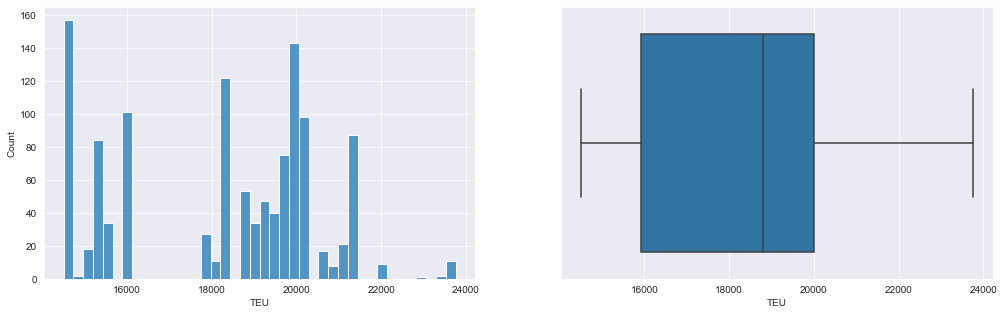

In [30]:
fig, axes = plt.subplots(1,2,figsize=(17,5))
sns.histplot(data = vessel_df, 
             x= 'TEU',
             element='bars',
             stat='count',
            bins=40,
            ax=axes[0])
sns.boxplot(data = vessel_df, x = 'TEU',ax=axes[1]);

In [22]:
vessel_df['TEU'].describe()

count     1202.000000
mean     18209.474210
std       2359.539667
min      14500.000000
25%      15908.000000
50%      18800.000000
75%      20000.000000
max      23756.000000
Name: TEU, dtype: float64

### The below is an alternative solution in case we had many outliners, for replacing the TEUs based on their port of call

We would try to replace the TEU value with the mean TEU value group by PORT_NAME (after excluded the outliners from the calculation of the mean)

In [116]:
mean_teu_per_port = vessel_df[~((vessel_df['IMO']==9321483) | (vessel_df['IMO']==9321495))].groupby(by='PORT_NAME').mean()['TEU']
mean_teu_per_port

PORT_NAME
A    18313.301818
B    18166.634921
C    18040.973404
D    18363.858974
Name: TEU, dtype: float64

In [127]:
def my_f(x,y):
    if (x > 30000) or (x < 10000):
        if y == 'A':
            return round(mean_teu_per_port['A'])
        if y == 'B':
            return round(mean_teu_per_port['B'])
        if y == 'C':
            return round(mean_teu_per_port['C'])
        if y == 'D':
            return round(mean_teu_per_port['D'])
    else:
        return x     

In [132]:
vessel_df['TEU'] = vessel_df[['TEU','PORT_NAME']].apply(lambda row: my_f(row['TEU'], row['PORT_NAME']), axis=1)

In [134]:
vessel_df['TEU'].describe()

count     1202.000000
mean     18226.925125
std       2349.485266
min      14500.000000
25%      15908.000000
50%      18800.000000
75%      20000.000000
max      23756.000000
Name: TEU, dtype: float64

In [31]:
# IF YOU RUN THE ABOVE PART, PLEASE RERUN THE BELOW CODE TO CORRECT THE TEU VALUES
vessel_df['TEU'] = vessel_df[['TEU','IMO']].apply(lambda row: correct_teu(row['TEU'], row['IMO']), axis=1)

### Question B

In [56]:
vessel_df['Year'] = vessel_df['TIMESTAMP'].dt.strftime('%Y')
vessel_df['Month'] = vessel_df['TIMESTAMP'].dt.strftime('%B')

In [57]:
vessel_df.head(3)

,IMO,SHIP_ID,TEU,PORT_NAME,TIMESTAMP,yyyy-mm,yyyy,mm,Year,Month
0,9784269,5098185,15226,A,2019-01-01,2019-01,2019,January,2019,January
1,9795622,5640800,21237,A,2019-01-01,2019-01,2019,January,2019,January
2,9811000,5631605,20000,A,2019-01-01,2019-01,2019,January,2019,January


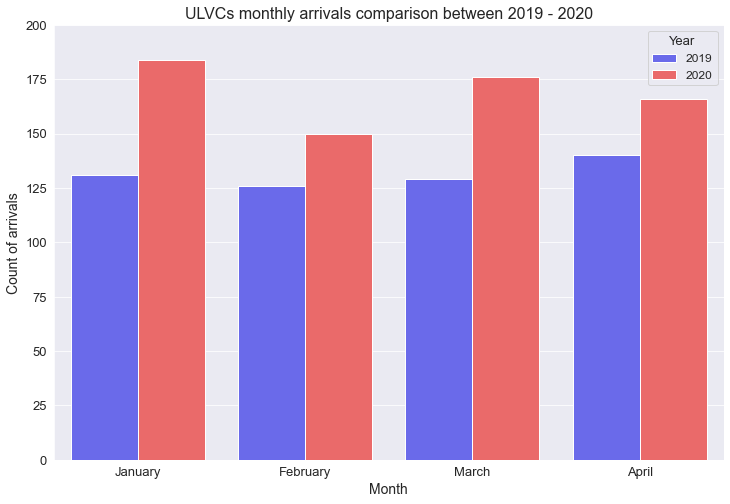

In [97]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(x='Month', hue='Year', data = vessel_df, ax=ax1, palette = 'seismic')
ax1.set_title('ULVCs monthly arrivals comparison between 2019 - 2020', fontsize=16)
ax1.set_ylabel('Count of arrivals', fontsize=14)
ax1.set_xlabel('Month',fontsize=14)
ax1.set_ylim(0, 200)
ax1.tick_params(labelsize=13)
ax1.legend(title='Year', title_fontsize=13, fontsize=12);

Based on the above graph we can notice the following:

1. There has been a significant increase on ULCVs arrivals within a year (this could be due to investements to ports infrastructures, world economy expansions etc).
2. February is the month with the less arrivals
3. For 2020 the month with the most arrivals was January, while for 2019 was April.